Bayesian Statistics Homework 3

\author{Rahul Bhatia}

Author: Rahul Bhatia (rb3318)
Due Monday, 10/19/20


In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.special as special

# Problem 1

In [22]:
survey = pd.DataFrame.from_dict({
    "county":  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "approve": [12, 90, 80, 5, 63, 15, 67, 22, 56, 33],
    "disapprove": [50, 150, 63, 10, 63, 8, 56, 19, 63, 19],
}).set_index('county')
survey.head()

approve  disapprove
county                     
1            12          50
2            90         150
3            80          63
4             5          10
5            63          63

## Part (A)

In [115]:
from tqdm.notebook import trange, tqdm

In [119]:
logit_mu_grid = np.linspace(-1.5, 1.5, 100)
log_psi_grid = np.linspace(0.1, 6, 100)
log_post = np.zeros((100, 100))


def log_post_fun(alpha, beta, y, n):
    """log Pr(alpha, beta | y)"""
    J = len(y)
    log_post = (-2.5 * np.log(alpha + beta)
                - J * special.beta(alpha, beta)
                + np.sum(np.log(special.beta(
                    alpha + y,
                    beta + n - y))))
    return log_post


y = survey.approve
n = survey.approve + survey.disapprove
for i, logit_mu in enumerate(logit_mu_grid):
    for j, log_psi in enumerate(log_psi_grid):
        mu = special.expit(logit_mu)
        psi = np.exp(log_psi)
        alpha = mu * psi
        beta = (1 - mu) * psi
        log_post[i][j] = (
            np.log(alpha)
            * np.log(beta)
            * log_post_fun(alpha, beta, y, n))
log_post = log_post / np.max(log_post)
post = np.exp(log_post)
post_logit_mu_likelihood = np.sum(post, axis=1)
post_logit_mu = post_logit_mu_likelihood / post_logit_mu_likelihood.sum()

In [120]:
post_logit_mu_dist = stats.rv_discrete(values=(logit_mu_grid, post_logit_mu))
SAMPLE_SIZE = 100
logit_mu_sim = np.zeros(SAMPLE_SIZE)
log_psi_sim = np.zeros(SAMPLE_SIZE)
for s in range(SAMPLE_SIZE):
    i = post_logit_mu_dist.rvs(1)
    j = stats.rv_discrete(values=(log_psi_grid, post[i] / np.sum(post[i]))).rvs(1)
    logit_mu_sim[s] = logit_mu_grid[i]
    log_psi_sim[s] = log_psi_grid[j]

In [160]:
mu_sim = special.expit(logit_mu_sim)
psi_sim = np.exp(log_psi_sim)
alpha_sim = mu_sim * psi_sim
beta_sim = (1 - mu_sim) * psi_sim

theta_sim_c = {}
for county in range(1, 11):
    theta_sim_c[county] = np.concatenate([
        stats.beta(survey.xs(county).approve + alpha, 
                   survey.xs(county).disapprove + beta).rvs(1)
        for alpha, beta in zip(alpha_sim, beta_sim)])
mc = pd.DataFrame(theta_sim_c)

In [164]:
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.scatter(x=y/n, y=mc.median())
ax.vlines(x=y/n, ymin=mc.quantile(0.05), ymax=mc.quantile(0.95))
ax.plot([0,1],[0,1], transform=ax.transAxes, color='black', linestyle='--')
ax.set_xlabel("Sample Proportions")
ax.set_ylabel("Posterior 90% Interval")
ax.set_title("Posterior Medians vs Sample Proportions")

Text(0.5, 1.0, 'Posterior Medians vs Sample Proportions')

## Part (B)

In [179]:
post_theta_10 = mc[10]
post_y_10 = np.concatenate([stats.binom(20, theta_10).rvs(1) for theta_10 in post_theta_10])
plt.hist(post_y_10)
plt.title("Histogram of Posterior Samples for Y_10")
plt.xlabel("Y_10")
plt.axvline(x=np.quantile(post_y_10, 0.95), ymin=0, ymax=1, color='red')
plt.axvline(x=np.quantile(post_y_10, 0.05), ymin=0, ymax=1, color='red')


## Part (C)

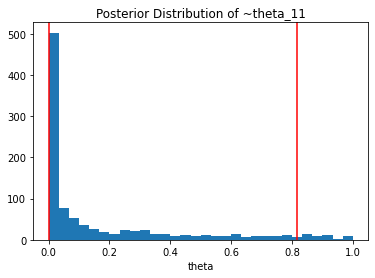

In [185]:
logit_mu_sim = np.zeros(SAMPLE_SIZE)
log_psi_sim = np.zeros(SAMPLE_SIZE)
for s in range(SAMPLE_SIZE):
    i = post_logit_mu_dist.rvs(1)
    j = stats.rv_discrete(values=(log_psi_grid, post[i] / np.sum(post[i]))).rvs(1)
    logit_mu_sim[s] = logit_mu_grid[i]
    log_psi_sim[s] = log_psi_grid[j]
mu_sim = special.expit(logit_mu_sim)
psi_sim = np.exp(log_psi_sim)
alpha_sim = mu_sim * psi_sim
beta_sim = (1 - mu_sim) * psi_sim
theta_sim = np.concatenate([stats.beta(alpha, beta).rvs(1) for alpha, beta in zip(alpha_sim, beta_sim)])
plt.hist(theta_sim, bins=30)
plt.title("Posterior Distribution of ~theta_11")
plt.xlabel("theta")
plt.axvline(x=np.quantile(theta_sim, 0.05), ymin=0, ymax=1, color='red')
plt.axvline(x=np.quantile(theta_sim, 0.95), ymin=0, ymax=1, color='red')

## Part(D)

In [188]:
y_11_sim = np.concatenate([stats.binom(20, theta).rvs(1) for theta in theta_sim])
plt.hist(y_11_sim)
plt.title("Posterior Distribution of ~y_11")
plt.xlabel("y_11")
plt.axvline(x=np.quantile(y_11_sim, 0.05), ymin=0, ymax=1, color='red')
plt.axvline(x=np.quantile(y_11_sim, 0.95), ymin=0, ymax=1, color='red')

# Question 2

In [189]:
studytime = pd.DataFrame({
    "school": range(1, 9),
    "n": [25, 23, 20, 24, 24, 22, 22, 20],
    "y_j": [9.5, 7.0, 8.0, 6.2, 10.8, 6.2, 6.1, 7.4],
})

## Part (A) Posterior Intervals for Study Time by School

# Question 3

## Part(A)

In [198]:
y_a = [12, 9, 12, 14, 13, 13, 15, 8, 15, 6]
y_b = [11, 11, 10, 8, 8, 8, 7, 10, 6, 8, 8, 9, 7]
# From conjugacy, we know that p(theta | x) ~ Gamma(sum(x) + alpha, n + B)
print("Interval for theta_a: "
      f"{stats.gamma(np.sum(y_a) + 120, scale=1 / (len(y_a) + 10)).interval(0.9)}")
print("Interval for theta_b: "
      f"{stats.gamma(np.sum(y_b) + 12, scale=1 / (len(y_b) + 1)).interval(0.9)}")


Interval for theta_a: (10.612946330494857, 13.143892125462981)
Interval for theta_b: (7.524545466079717, 10.128063639624974)


## Part (B)

In [200]:
SAMPLE_SIZE = 1000
post_a = stats.gamma(np.sum(y_a) + 120, scale=1 / (len(y_a) + 10))
post_b = stats.gamma(np.sum(y_b) + 12, scale=1 / (len(y_b) + 1))
print("Prob that theta_a > theta_b: "
      f"{(post_a.rvs(SAMPLE_SIZE) > post_b.rvs(SAMPLE_SIZE)).mean()}")


Prob that theta_a > theta_b: 0.996


## Part (C)

In [201]:
post_a_sim = post_a.rvs(SAMPLE_SIZE)
post_b_sim = post_b.rvs(SAMPLE_SIZE)
post_pred_y_a = np.concatenate([stats.poisson(post_a).rvs(1) for post_a in post_a_sim])
post_pred_y_b = np.concatenate([stats.poisson(post_b).rvs(1) for post_b in post_b_sim])

print("Prob that y_tilde_a > y_tilde_b: "
      f"{(post_pred_y_a > post_pred_y_b).mean()}")

Prob that y_tilde_a > y_tilde_b: 0.714


# Question 4

In [202]:
S = 1000
n_a = 10
n_b = 13
theta_a_sim = post_a.rvs(S)
theta_b_sim = post_b.rvs(S)

y_A_rep = np.array([stats.poisson(theta_a).rvs(n_a) for theta_a in theta_a_sim])
y_B_rep = np.array([stats.poisson(theta_b).rvs(n_b) for theta_b in theta_b_sim])


## Part (A)

In [208]:
np.mean(y_a)

11.7

Text(0.5, 1.0, 'Y_a Posterior vs Sample')

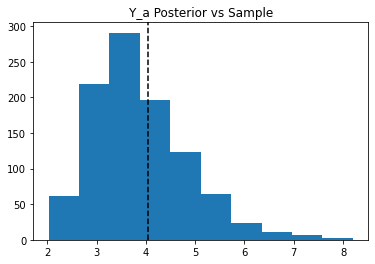

In [215]:
fig, ax = plt.subplots()
ax.hist(y_A_rep.mean(axis=1) / y_A_rep.std(axis=1))
ax.axvline(x=np.mean(y_a) / np.std(y_a), ymin=0, ymax=1, color='black', linestyle='--')
ax.set_title("Y_a Posterior vs Sample")



Based on the observed sample statistic and the model, our model seems to fit the data for y_a and theta_a quite well. 

## Part (B)

Text(0.5, 1.0, 'Y_b Posterior vs Sample')

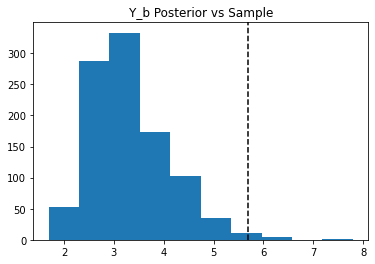

In [216]:
fig, ax = plt.subplots()
ax.hist(y_B_rep.mean(axis=1) / y_B_rep.std(axis=1))
ax.axvline(x=np.mean(y_b) / np.std(y_b), ymin=0, ymax=1, color='black', 
           linestyle='--')
ax.set_title("Y_b Posterior vs Sample")

Based on our observed sample statistic, our model for Y_b doesn't seem to fit the data very well. 

# Problem 5